In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

#### Read in Data and Recreate model

In [3]:
import os

os.getcwd()

'/home/yilin/tutorial'

In [4]:
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

In [6]:
imputer = SimpleImputer(strategy = "median")

imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [7]:
def mae(y_true, y_pred):
    return(np.mean(abs(y_pred - y_true)))

In [8]:
model = RandomForestRegressor(max_depth=20, max_features=None, max_samples=0.8,
                      min_samples_split=4, n_estimators=350, random_state=1284)

model.fit(X,y)

RandomForestRegressor(max_depth=20, max_features=None, max_samples=0.8,
                      min_samples_split=4, n_estimators=350, random_state=1284)

In [9]:
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.2428


## **Interprete Model**

- Feature Importance
- Locally Interpretable Model-agnostic Explainer (LIME)
- Examining a single decision tree in the ensemble.

### Feature Importance

Remember we are trying to interprete a random forest model, which is nothing but an ensemble of serveral decision trees.

One of the basic ways of interpreting an ensemble of decision trees is **feature Importance**.

In [17]:
feature_importance = pd.DataFrame({"Features" : train_features.columns,
                                  "Feature Importance" : model.feature_importances_})

feature_importance = feature_importance.sort_values("Feature Importance", ascending = False).reset_index(drop = True)

feature_importance.head(10)

,Features,Feature Importance
0,Site EUI (kBtu/ft²),0.618043
1,Weather Normalized Site Electricity Intensity ...,0.153997
2,Largest Property Use Type_Multifamily Housing,0.055852
3,Record Number,0.030296
4,log_Direct GHG Emissions (Metric Tons CO2e),0.024093
5,Year Built,0.023225
6,Street Number,0.019182
7,"NYC Borough, Block and Lot (BBL)",0.013290
8,Order,0.013189
9,Largest Property Use Type_Non-Refrigerated War...,0.010979


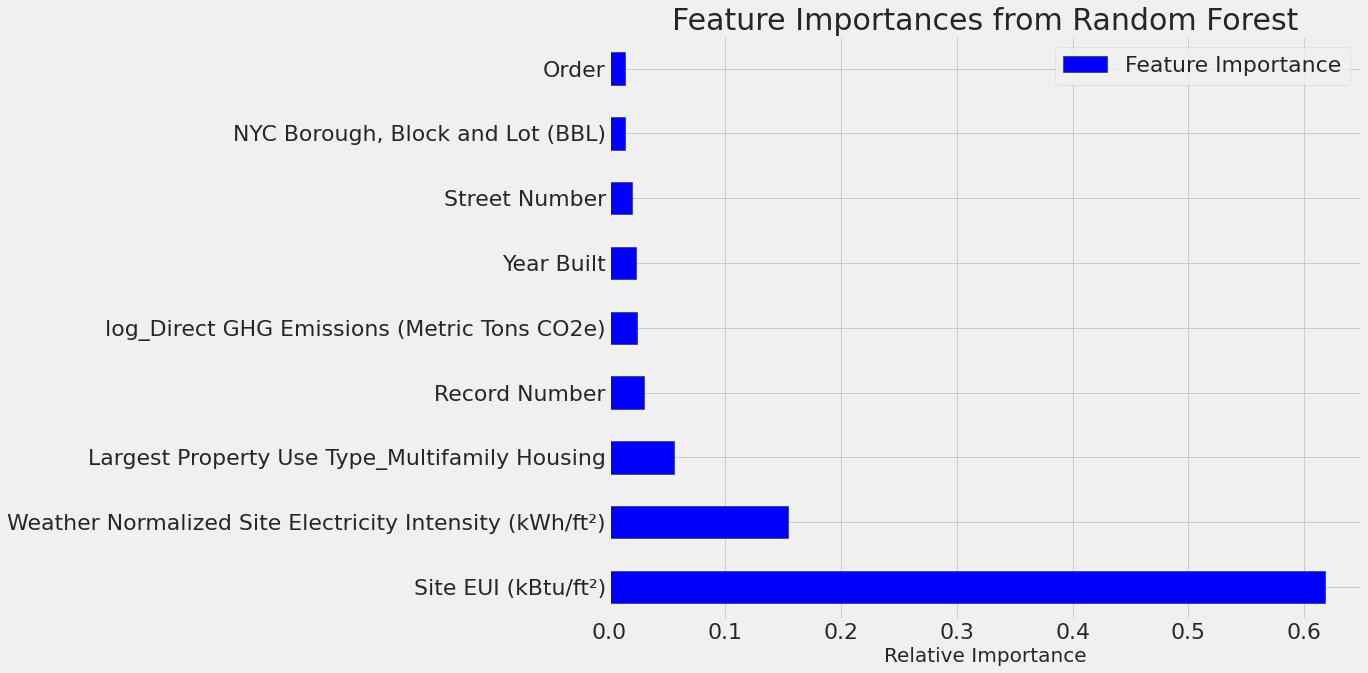

In [20]:
figsize(12,10)
plt.style.use("fivethirtyeight")

feature_importance.iloc[:9,:].plot(x = "Features", y = "Feature Importance", edgecolor = 'k', kind = 'barh', color = 'blue')
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);


#### Use Feature Importances for Feature Selection

We use linear regression with these 10 most important features.

In [42]:
important_features = feature_importance["Features"][:10]

indices = [list(train_features.columns).index(x) for x in important_features]

X_reduced = X[:,indices]
X_test_reduced = X_test[:,indices]

print(X_reduced.shape)

(7011, 10)


In [44]:
lr = LinearRegression()

lr.fit(X,y)
lr_full_pred = lr.predict(X_test)

lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.2185.
Linear Regression Reduced Results: MAE = 14.0739.


Reducing the features did not improve the linear regression results! It turns out that the extra information in the features with low importance do actually improve performance.

In [46]:
reduced_rf = RandomForestRegressor(max_depth=20, max_features=None, max_samples=0.8,
                      min_samples_split=4, n_estimators=350, random_state=1284)

reduced_rf.fit(X_reduced, y)
reduced_rf_pred = reduced_rf.predict(X_test_reduced)

print('Random Forest Reduced Results: MAE = %0.4f' % mae(y_test, reduced_rf_pred))

Random Forest Reduced Results: MAE = 9.6682


Sightly worse than the random forest with full features!

### Locally Interpretable Model-agnostic Explanations

LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

In [47]:
# find residuals
residuals = abs(reduced_rf_pred - y_test)

wrong = X_test_reduced[np.argmax(residuals),:]
best = X_test_reduced[np.argmin(residuals), :]

In [62]:
print(best.shape)
print(best.reshape(1,-1).shape)

(10,)
(1, 10)


In [52]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(important_features))

Prediction: 23.4875
Actual Value: 98.0000


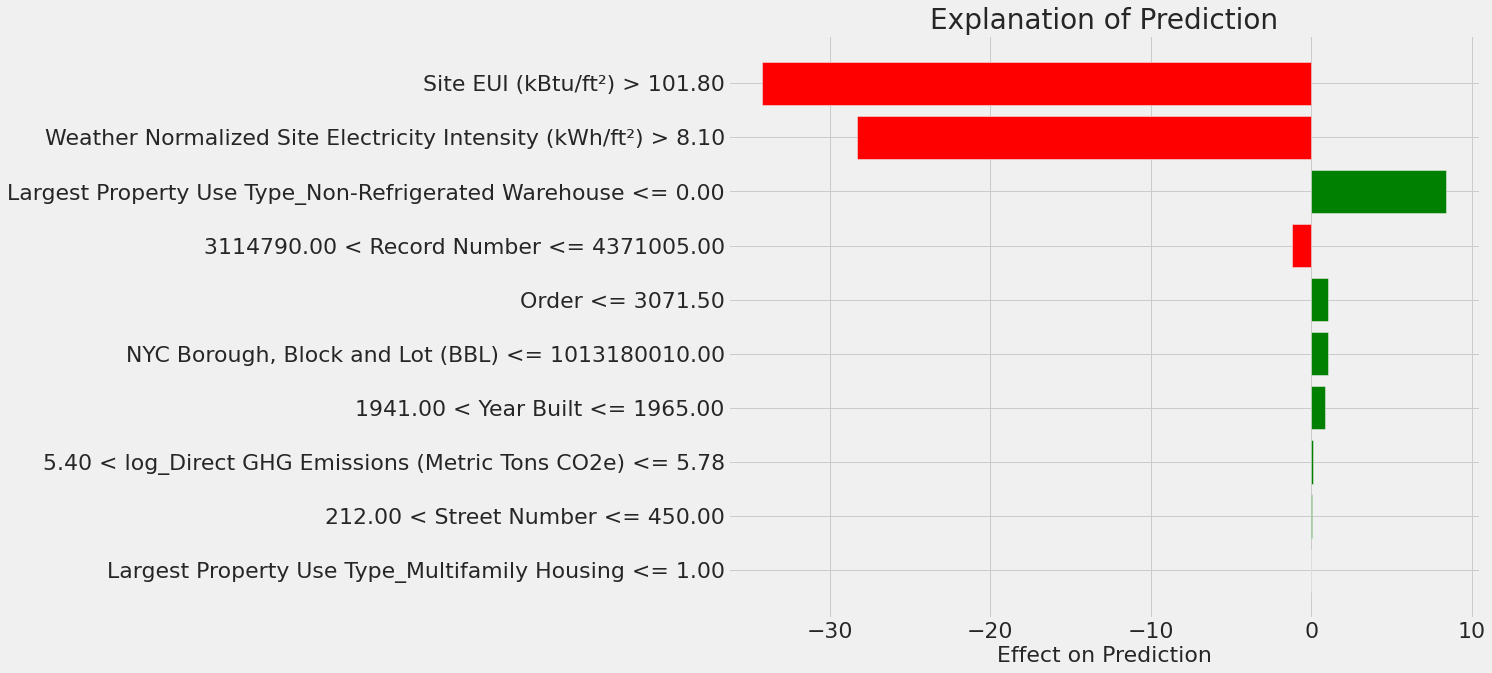

In [54]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % reduced_rf.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# explain the result using the explainer
wrong_exp = explainer.explain_instance(data_row = wrong, predict_fn = reduced_rf.predict)

wrong_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [55]:
wrong_exp.show_in_notebook(show_predicted_value=False)

We can interpret this as saying that our model thought the Energy Star Score would be much lower than it actually was because the Site EUI was high. However, in this case, the score was 100 despite the high value of the EUI. While this significant mistake (off by 88 points!) might initially have been confusing, now we can see that in reality, the model was reasoning through the problem and just arrived at the incorrect value! A human going over the same process probably would have arrived at the same conclusion (if they had the patience to go through all the data).

Prediction: 100.0000
Actual Value: 100.0000


Text(0.5, 0, 'Effect on Prediction')

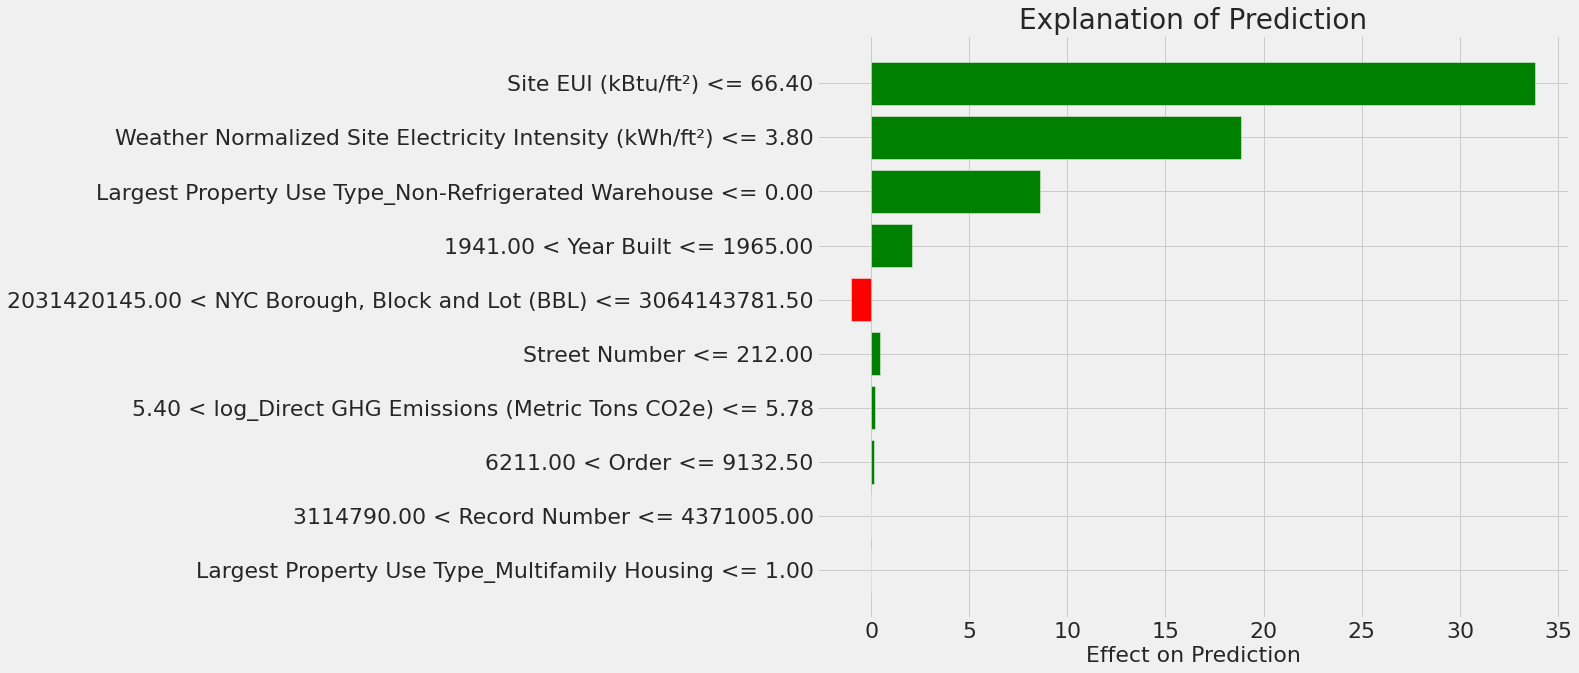

In [64]:
print("Prediction: %0.4f" % reduced_rf.predict(best.reshape(1,-1)))
print("Actual Value: %0.4f" % y_test[np.argmin(residuals)])

best_exp = explainer.explain_instance(data_row = best, predict_fn = reduced_rf.predict)

best_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

### Examine a single decision tree

First extract a tree from the forest and then save it using sklearn.tree.export_graphviz. This saves the tree as a .dot file which can be converted to a png using command line instructions in the Notebook.

In [77]:
single_tree = reduced_rf.estimators_[112]
tree.export_graphviz(single_tree, out_file = 'images/tree.dot',
                     rounded = True, 
                     feature_names = important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(max_depth=20, min_samples_split=4, random_state=220332658)

In [78]:
# create a smaller tree

tree.export_graphviz(single_tree, out_file = 'images/small_tree.dot',
                     rounded = True, 
                     feature_names = important_features,
                     filled = True,
                     max_depth = 3)